
# BlueBikes Casestudy
This notebook is analyzing the trip data of Blue Bikes (originally Hubway) in Boston. Blue Bikes (https://www.bluebikes.com/) is a public bike share system that operates in the Greater Boston area. We are interested in exploring the bike share operations from the data available on https://www.bluebikes.com/system-data. We will utilize the “Bluebikes trip history data” as well as “the list of GPS coordinates and number of docks for each station” available on the website.

We are analysing the data from May 2015 to Aug 2020 Data

## 0. Importing Library and Dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing 
plt.style.use('seaborn-pastel')

In [2]:
#Initialize the Variable with starting values 
data_list = (glob.glob("C:/Users/tommy/OneDrive/(PYTHON)/5106/Assignment 2 BluBike/*.csv"))
df_all = pd.DataFrame()
trips = []
dates = []

#Appending all other datas with additional values
for n in range(60):
    df = pd.read_csv(data_list[n], usecols = ['tripduration', 'starttime'])
    trips.append(len(df))
    dates.append(pd.to_datetime(df['starttime'][0]))
    df_all = pd.concat([df_all,df], axis=0, ignore_index = True)
del df_all

ser = pd.Series(dates, name= 'Date').dt.date

## 1.A. EDA - Line plot of Trips and Months

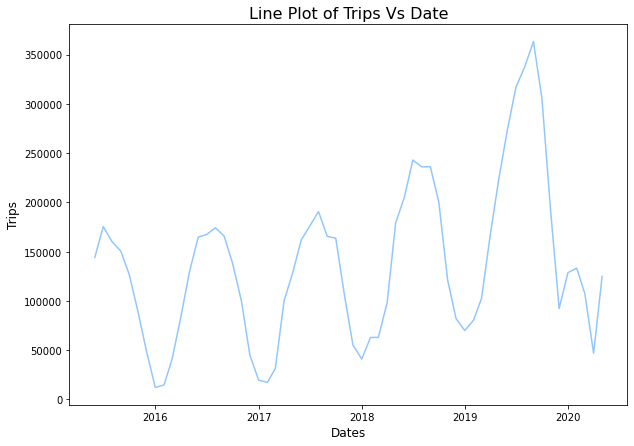

In [3]:
# plotting the line plot
plt.figure(figsize = (10,7))
plt.plot(ser, trips)
plt.title('Line Plot of Trips Vs Date', fontsize = 16)
plt.xlabel('Dates', fontsize = 12)
plt.ylabel('Trips', fontsize = 12)
plt.show()

bikes_df = pd.DataFrame({'Date': ser, 'Trip': trips})
init = bikes_df

---
**Observations**
We can observe that there is seasonality in the annual data. One possible explanation for this is in Boston there are 4 seasons, and this 4 seasons will definitely affect the weather for customer's if they want to ride the bikes. We will break it in the charts below
---

## 1.B. EDA - Seasonal Decomposition

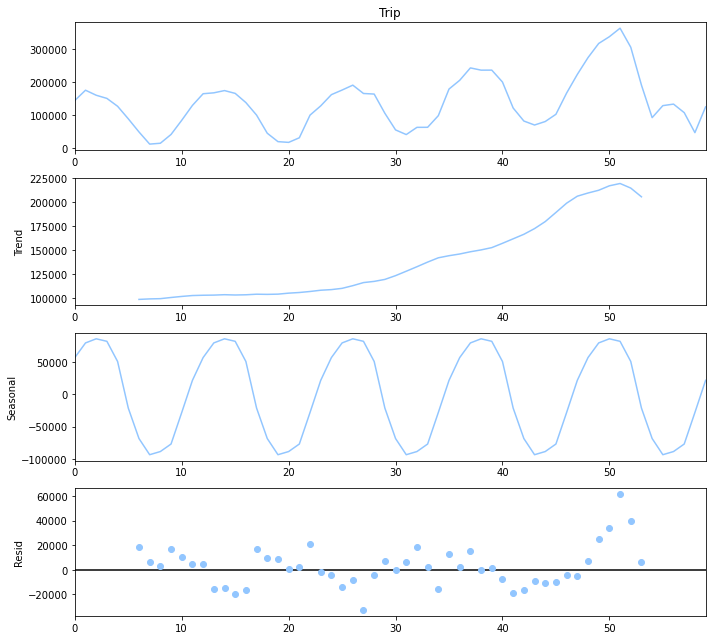

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10, 9)
result = seasonal_decompose(bikes_df['Trip'], model='additive', period = 12)
result.plot()
plt.show()

---
**Observations**:
- Observed an upward from the year 2016 - 2020
- Annual Seasonality, on October - January there is a tremendous drop in the total trips, perhaps as it is winter season, that it's too cold to use the bike
- In 2019 October there is a shock, sudden surge of use of bikes
- In 2020 March there is sudden drop, perhaps due to covid-19
---

# 3.0 Model

In this section we are going to explore different methods to forecast the monthly trips of the Blue Bike, from the May 2015 data to May 2019, to forecast the monthly trips from June 2016 to 2020 May. The methods that we are going to explore:
1. Moving Average
2. Simple Exponential Smoothing
3. Holt's Method
4. Wilner Holt's Method
5. ARIMA

## 3.1 Moving Average (3 months)

          Date    Trip  MA_forecast
48  2019-06-01  274022     164049.0
49  2019-07-01  316931     221267.0
50  2019-08-01  337443     271346.0
51  2019-09-01  363185     309465.0
52  2019-10-01  305504     339186.0
53  2019-11-01  190759     335377.0
54  2019-12-01   92208     286483.0
55  2020-01-01  128598     196157.0
56  2020-02-01  133235     137188.0
57  2020-03-01  107350     118014.0
58  2020-04-01   46793     123061.0
59  2020-05-01  124879      95793.0


<function matplotlib.pyplot.show(close=None, block=None)>

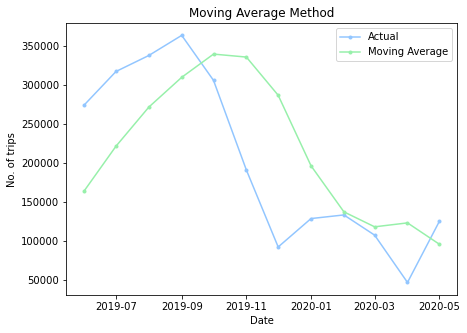

In [5]:
# using n=3 for moving average
n_moving_average = 3

# moving average method
fitted_values= list(bikes_df['Trip'].rolling(n_moving_average).mean())
fitted_values.pop(len(fitted_values)-1)

# compiling it into dataframe
bikes_df= pd.concat([bikes_df, 
                     pd.DataFrame(fitted_values[47:], index= bikes_df.index[48:], columns=['MA_forecast'])]
                    ,axis=1)
del fitted_values

# print the dataframe results
bikes_df['MA_forecast'] = bikes_df['MA_forecast'].round(0)
print(bikes_df.tail(12))

# plotting the data
plt.figure(figsize = (7,5))
plt.plot(bikes_df['Date'][-12:], bikes_df['Trip'][-12:], label = 'Actual', marker = '.')
plt.plot(bikes_df['Date'][-12:], bikes_df['MA_forecast'][-12:], label = 'Moving Average', marker = '.')

plt.title('Moving Average Method')
plt.ylabel('No. of trips')
plt.xlabel('Date')
plt.legend()
plt.show

---
#### Observation 3.1:
We observe that the Moving Average prediction is not very good in predicting the trips, as the data is observed with seasonality and trend, the prediction become lagging as it took the average of the previous 3 months.

---

## 3.2 Simple Exponential Smoothing Method

          Date    Trip  SES_forecast
48  2019-06-01  274022      177127.0
49  2019-07-01  316931      225575.0
50  2019-08-01  337443      271253.0
51  2019-09-01  363185      304348.0
52  2019-10-01  305504      333766.0
53  2019-11-01  190759      319635.0
54  2019-12-01   92208      255197.0
55  2020-01-01  128598      173703.0
56  2020-02-01  133235      151150.0
57  2020-03-01  107350      142193.0
58  2020-04-01   46793      124771.0
59  2020-05-01  124879       85782.0


<function matplotlib.pyplot.show(close=None, block=None)>

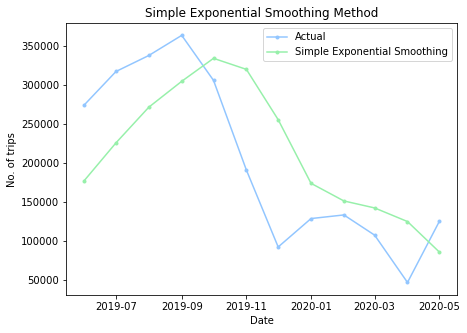

In [6]:
bikes_df_test = bikes_df.iloc[-12:,:2]
SES_forecast = []
SES_index=[]

for i in range(12):
    bikes_df_train = bikes_df.iloc[:-12+i,:2]
    SES_model = SimpleExpSmoothing(bikes_df_train['Trip'].astype('float')).fit(smoothing_level = 0.5)
    SES_forecast.append(round(SES_model.forecast().values[0]))
    SES_index.append(SES_model.forecast().index)

bikes_df['SES_forecast'] = pd.DataFrame(SES_forecast, index = bikes_df.index[-12:])
print(bikes_df[['Date', 'Trip', 'SES_forecast']].tail(12))

# plotting the data
plt.figure(figsize = (7,5))
plt.plot(bikes_df['Date'][-12:], bikes_df['Trip'][-12:], label = 'Actual', marker = '.')
plt.plot(bikes_df['Date'][-12:], bikes_df['SES_forecast'][-12:], label = 'Simple Exponential Smoothing', marker = '.')

plt.title('Simple Exponential Smoothing Method')
plt.ylabel('No. of trips')
plt.xlabel('Date')
plt.legend()
plt.show

---
#### Observation 3.2:
We observe that the Simple Exponential Smoothing Prediction is not very good in predicting the trips, as the data is observed with seasonality and trend, the prediction become lagging.

---

## 3.3. Holt’s method with α=0.3 and β=0.1

          Date    Trip  Holts_forecast
48  2019-06-01  274022        155682.0
49  2019-07-01  316931        196216.0
50  2019-08-01  337443        241084.0
51  2019-09-01  363185        281536.0
52  2019-10-01  305504        320025.0
53  2019-11-01  190759        329227.0
54  2019-12-01   92208        297091.0
55  2020-01-01  128598        238884.0
56  2020-02-01  133235        205747.0
57  2020-03-01  107350        181767.0
58  2020-04-01   46793        154983.0
59  2020-05-01  124879        114822.0


<function matplotlib.pyplot.show(close=None, block=None)>

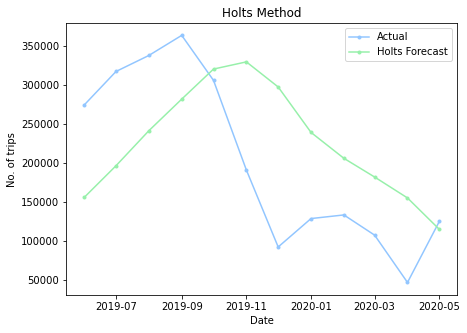

In [7]:
from statsmodels.tsa.api import Holt

Holts_forecast = []

for i in range(12):
    bikes_df_train = bikes_df['Trip'][:-12+i]
    Holter_model = Holt(bikes_df_train).fit(smoothing_level=0.3, smoothing_slope=0.1, optimized=False)
    Holts_forecast.append(round(Holter_model.forecast().values[0]))
    
bikes_df['Holts_forecast'] = pd.Series(Holts_forecast, index = bikes_df.index[-12:])
print(bikes_df[['Date', 'Trip', 'Holts_forecast']].tail(12))

# plotting the data
plt.figure(figsize = (7,5))
plt.plot(bikes_df['Date'][-12:], bikes_df['Trip'][-12:], label = 'Actual', marker = '.')
plt.plot(bikes_df['Date'][-12:], bikes_df['Holts_forecast'][-12:], label = 'Holts Forecast', marker = '.')

plt.title('Holts Method')
plt.ylabel('No. of trips')
plt.xlabel('Date')
plt.legend()
plt.show

## 3.4 Analysis of the three methods from 3.1 - 3.3

### 3.4.1 Line Plot

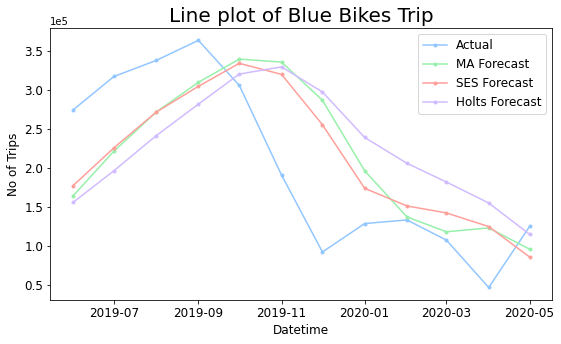

In [8]:
plt.figure(figsize = (9,5))
plt.plot(bikes_df['Date'][-12:], bikes_df['Trip'][-12:], label = 'Actual', marker='.')
plt.plot(bikes_df['Date'][-12:], bikes_df['MA_forecast'][-12:], label = 'MA Forecast', marker='.')
plt.plot(bikes_df['Date'][-12:], bikes_df['SES_forecast'][-12:], label = 'SES Forecast', marker='.')
plt.plot(bikes_df['Date'][-12:], bikes_df['Holts_forecast'][-12:], label = 'Holts Forecast', marker='.')

plt.title('Line plot of Blue Bikes Trip', fontsize=20)
plt.ticklabel_format(axis = 'y', style= 'sci', scilimits =(0,3))
plt.xlabel('Datetime',fontsize=12)
plt.ylabel('No of Trips',fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.show()  

### 3.4.2 MAD and MAPE analysis

In [9]:
from sklearn.metrics import mean_absolute_error
def Mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MA_forecast = np.array(bikes_df['MA_forecast'].iloc[-12:].values)
SES_forecast = np.array(bikes_df['SES_forecast'].iloc[-12:].values)
Holts_forecas = np.array(bikes_df['Holts_forecast'].iloc[-12:].values)
Actual = np.array(bikes_df['Trip'].iloc[-12:].values)

MAPE_MA = Mape(Actual, MA_forecast)
MAPE_SES = Mape(Actual, SES_forecast)
MAPE_Holts = Mape(Actual, Holts_forecast)

print('MAD for MA forecast: {:.1f}'.format(mean_absolute_error(Actual,MA_forecast)))
print('MAD for SES forecast: {:.1f}'.format(mean_absolute_error(Actual, SES_forecast)))
print('MAD for Holts forecast: {:.1f}'.format(mean_absolute_error(Actual, Holts_forecast)))
print('')
print('MAPE for MA forecast: {:.1f}%'.format(MAPE_MA))
print('MAPE for SES forecast: {:.1f}%'.format(MAPE_SES))
print('MAPE for Holts forecast: {:.1f}%'.format(MAPE_Holts))

MAD for MA forecast: 73796.6
MAD for SES forecast: 70695.2
MAD for Holts forecast: 95866.4

MAPE for MA forecast: 54.5%
MAPE for SES forecast: 52.7%
MAPE for Holts forecast: 73.4%


---
**Observations**
The performance of the forecast with the Moving Average, Simples Smoothing Exponential and Holts Method is not good to predict this time series. The reason behind this is because these models are not good in predicting data with seasonality.

Some suggestion in improving by using the difference of the numbers of trips to do the prediction. Other than that, perhaps other models may be used that is equipped to handle the seasonality of the data such as Holts-Winters' method or ARIMA. Therefore, now we are going to look into the Holts Winters' Method and ARIMA

---

### 3.5 Winter Holts Method

In [10]:
from statsmodels.tsa.api import ExponentialSmoothing

bikes_df_train = pd.DataFrame(bikes_df['Trip'][:-12])
Holts_Winters_forecast = []
bikes_df_train['Dates'] =  pd.date_range('6/1/2015', periods=48, freq='M')
bikes_df_train.set_index('Dates', inplace=True)

ES_bikes_df = ExponentialSmoothing(bikes_df_train['Trip'],trend='add', seasonal='add',seasonal_periods = 12, freq = 'M').fit()
Holts_Winters_forecast = ES_bikes_df.forecast(12)

bikes_df2 = init
bikes_df2 = pd.concat([bikes_df2, pd.Series(Holts_Winters_forecast.values, name ='Holts_Winters_forecast', index = bikes_df.index[-12:])], axis=1)
bikes_df2['Holts_Winters_forecast'] = bikes_df2['Holts_Winters_forecast'].round(0)

print(bikes_df2.tail(12))

          Date    Trip  Holts_Winters_forecast
48  2019-06-01  274022                241241.0
49  2019-07-01  316931                264234.0
50  2019-08-01  337443                259995.0
51  2019-09-01  363185                248336.0
52  2019-10-01  305504                221378.0
53  2019-11-01  190759                161355.0
54  2019-12-01   92208                123627.0
55  2020-01-01  128598                109062.0
56  2020-02-01  133235                119135.0
57  2020-03-01  107350                134125.0
58  2020-04-01   46793                188064.0
59  2020-05-01  124879                238436.0


<function matplotlib.pyplot.show(close=None, block=None)>

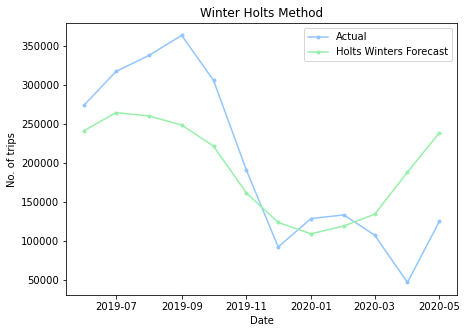

In [11]:
# plotting the data
plt.figure(figsize = (7,5))
plt.plot(bikes_df2['Date'][-12:], bikes_df2['Trip'][-12:], label = 'Actual', marker = '.')
plt.plot(bikes_df2['Date'][-12:], bikes_df2['Holts_Winters_forecast'][-12:], label = 'Holts Winters Forecast', marker = '.')

plt.title('Winter Holts Method')
plt.ylabel('No. of trips')
plt.xlabel('Date')
plt.legend()
plt.show

In [12]:
# Printing the Summary 
ES_bikes_df.summary()

Dep. Variable:,endog,No. Observations:,48
Model:,ExponentialSmoothing,SSE,8857921913.343
Optimized:,True,AIC,945.602
Trend:,Additive,BIC,975.541
Seasonal:,Additive,AICC,969.188
Seasonal Periods:,12,Date:,"Tue, 24 Nov 2020"
Box-Cox:,False,Time:,22:27:15
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3684854,alpha,True
smoothing_slope,2.0068e-09,beta,True


In [13]:
print('MAD for Holts-Winters forecast: {:.1f}'.format(mean_absolute_error(Actual, Holts_Winters_forecast)))
print('MAPE for Holts-Winters forecast: {:.1f}%'.format(Mape(Actual, Holts_Winters_forecast)))

MAD for Holts-Winters forecast: 61497.0
MAPE for Holts-Winters forecast: 50.3%


---
**Observations**:
With the Winter Holts' Method we can see that there is an improvement in the Mean Absolute Error (10,000) and MAPE (around 5%). As this method take seasonality into account, therefore we can see a better prediction. However, with rising trend we still observe the MAD and MAPE are still considerably large. We will try to use ARIMA and see if we can reduce the MAD and MAPE>


---

## 3.6 ARIMA 

### 3.6.1 ARIMA Model Summary

In [14]:
bikes_df_train = bikes_df2['Trip'][:-12]

import pmdarima as pm 
model = pm.auto_arima(bikes_df_train, seasonal = True, m=12, suppress_warnings=True) # m=seasonal length
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -394.273
Date:                            Tue, 24 Nov 2020   AIC                            794.545
Time:                                    22:27:19   BIC                            799.211
Sample:                                         0   HQIC                           796.156
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2913      0.146     -1.999      0.046      -0.577      -0.006
ma.S.L12      -0.2414      0.106     -2.272      0.023      -0.450      -0.033
sigma2      3.216e+08   3.19e-11   1.01e+19      0.000    3.22e+08    3.22e+08
===================================================================================
Ljung-Box (Q):                       28.59   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.73   Prob(JB):                         0.81
Heteroskedasticity (H):               0.93   Skew:                             0.20
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+36. Standard errors may be unstable.
"""

---
#### Observation:
Auto ARIMA model able to detect that this model is Seasonal model.
(p = 0, d = 1, q = 1) (P = 0, D = 1, Q = 1, S = 12)
d= 1 with S= 12, The Auto ARIMA Model use one level diferencing to minimise the effect of data seasonality
The model is MA(1).

---

### 3.6. ACF and PACF of fitted residuals
This is to verify whether there is MA/AR effect left on the ARIMA Models

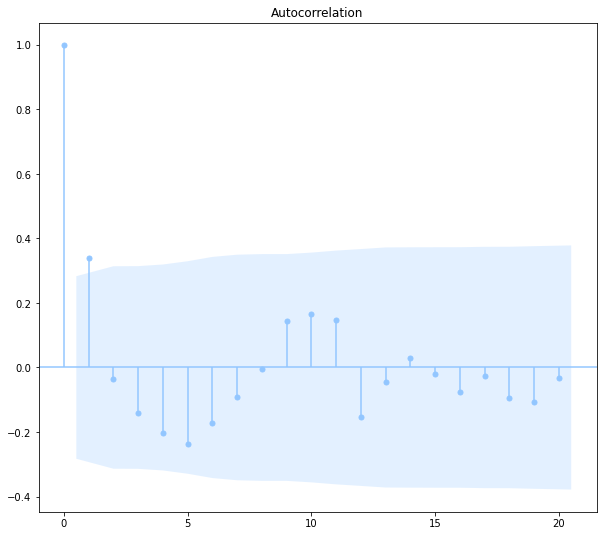

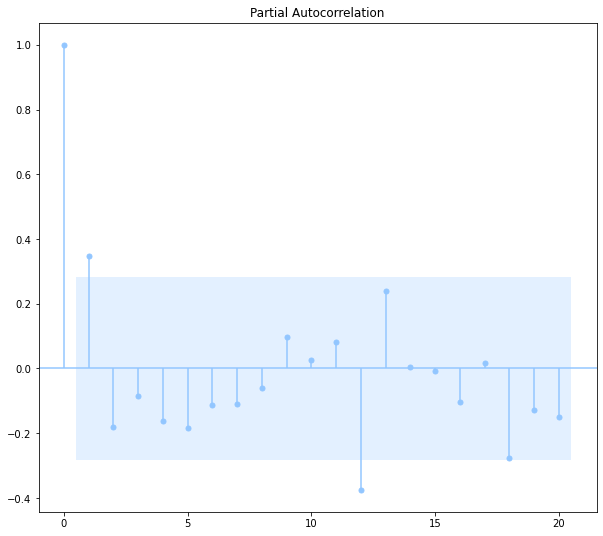

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(model.resid(),lags=20)
plt.show()
plot_pacf(model.resid(),lags=20)
plt.show()

---
#### Observation
Mostly the residual are within the baseline, with p = 2, q = 2, q = 12, that it is barely out of the baseline.
Therefore this will be a satsifactory model for the bluebike data.
---

#### e.Forecast the trips for 2019-06 to 2020-05 using the best fit ARIMA model and plot the predictions with 95% confidence intervals. [2 pts]


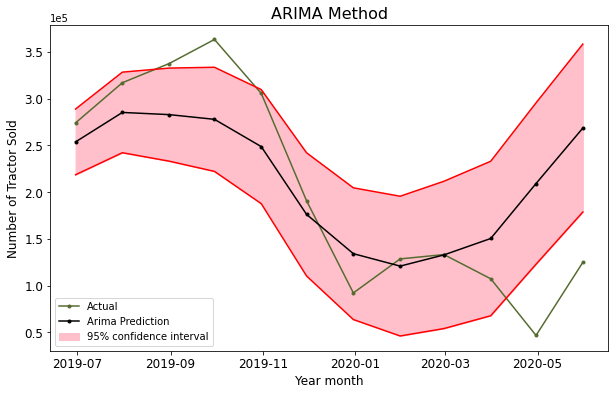

MAD for ARIMA forecast: 55215.6
MAPE for ARIMA forecast: 53.1%


In [16]:
pred, conf = model.predict(12, return_conf_int=True,alpha=0.05)
Test = pd.DataFrame()

Test['test_periods'] = pd.Series(pd.date_range('2019-06-01','2020-06-01', freq = 'M'))
Test['lower_bounds'] = [i[0] for i in conf ]
Test['upper_bounds'] = [i[1] for i in conf ]
Test['prediction'] = list(pred)

bikes_df_date = pd.Series(pd.date_range('2015-06-01','2020-06-01', freq = 'M'))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot_date( bikes_df_date[-12:], bikes_df['Trip'][-12:],linestyle = 'solid', markersize = 3, color = 'darkolivegreen', label='Actual')
plt.plot_date( Test['test_periods'], Test['prediction'], linestyle = 'solid', marker = '.', color = 'black', label= 'Arima Prediction')
plt.plot_date( Test['test_periods'], Test['upper_bounds'], linestyle = 'solid', markersize=0, color = 'red')
plt.plot_date( Test['test_periods'], Test['lower_bounds'], linestyle = 'solid', markersize=0, color = 'red')
plt.fill_between( Test['test_periods'].values, Test['lower_bounds'].values, Test['upper_bounds'].values, color='pink', label='95% confidence interval')

plt.ticklabel_format(axis = 'y', style= 'sci',scilimits =(0,3))
plt.title('ARIMA Method', fontsize = 16)
plt.xlabel('Year month',fontsize=12)
plt.ylabel('Number of Tractor Sold',fontsize=12)
plt.tick_params(labelsize=12)
plt.legend()
plt.show() 

# Performance Measurement
ARIMA_forecast =Test['prediction'].values
Actual = np.array(bikes_df['Trip'].iloc[-12:].values)

MAPE_ARIMA = Mape(Actual, ARIMA_forecast)
print('MAD for ARIMA forecast: {:.1f}'.format(mean_absolute_error(Actual,ARIMA_forecast)))
print('MAPE for ARIMA forecast: {:.1f}%'.format(MAPE_ARIMA))

---
**Observations:**
Though the MAD and MAPE for ARIMA is not as good as Winter Holt's method, but we can see in terms of the fluctuations ARIMA able to follow the shape of the actual trip closely.
---


## 4.0. Exploring Daily Ridership and connection with auxiliary data sets
Data Source: Weather data: https://www.meteoblue.com/en/weather/archive/era5/boston_united-states-of-america_4930956.

In [17]:
data_df = pd.read_csv('dataexport_20200914T084245.csv', header = [4])
data_df = data_df.iloc[5:,]
data_df.columns = data_df.columns.map(''.join)

date = pd.to_datetime(data_df['variable'], errors='coerce').dt.date
data_df.drop('variable', axis=1, inplace=True)
data_df = data_df.astype('float64')
data_df['Date'] = date
data_agg = data_df.groupby('Date').mean()

#initialising the data
test = []
dateindex = []
mdate = []
data_2019 = pd.DataFrame()

#iterating the dates 
start_dt = datetime.date(2019,1,1)
end_dt = datetime.date(2020,1,1)
delta_dt = relativedelta(months=1)
while (start_dt < end_dt):
    mdate.append(start_dt)
    start_dt = start_dt + delta_dt
mdate = pd.Series(mdate, name = 'date')
mdate = pd.to_datetime(mdate).dt.strftime('%Y%m')

for mdate in mdate:
    data = pd.read_csv(str(mdate) + '-bluebikes-tripdata.csv')
    data['starttime'] = pd.to_datetime(data['starttime'],errors='coerce').dt.date
    data_2019 = pd.concat([data_2019, data], axis =0)
    temp_df = data['starttime'].groupby(data.starttime).count()
    for val in list(temp_df.values):
        test.append(val) 
    for ind in list(temp_df.index):
        dateindex.append(ind)

data_agg = pd.concat([data_agg, pd.Series(test, index= dateindex, name = 'Daily Trip')], axis=1)

C:\Users\tommy\anaconda3\envs\python3.7\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



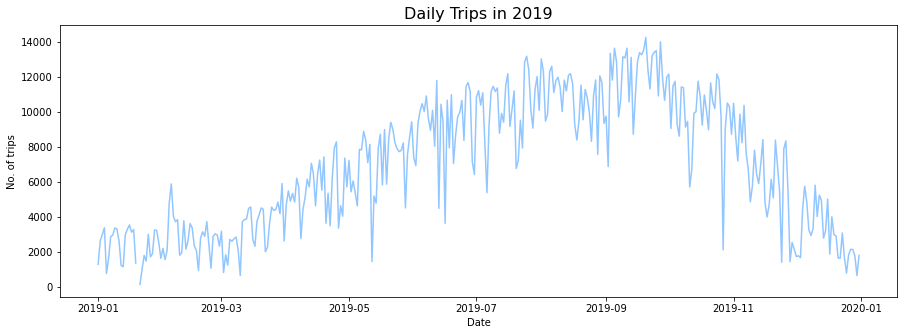

In [18]:
plt.figure(figsize=(15,5))
plt.title('Daily Trips in 2019', fontsize = 16)
plt.ylabel('No. of trips')
plt.xlabel('Date')
plt.plot(data_agg['Daily Trip'])

In [19]:
data_agg.drop(['Temperature.1', 'Soil Temperature'], axis=1, inplace=True)
data_agg.columns

Index(['Temperature', 'Relative Humidity', 'Mean Sea Level Pressure',
       'Precipitation Total', 'Precipitation Runoff', 'Snowfall Amount',
       'Snow Depth', 'Cloud Cover Total', 'Cloud Cover High',
       'Cloud Cover Medium', 'Cloud Cover Low', 'Sunshine Duration',
       'Shortwave Radiation', 'Longwave Radiation', 'UV Radiation',
       'Direct Shortwave Radiation', 'Diffuse Shortwave Radiation',
       'Evapotranspiration', 'Potential Evaporation',
       'FAO Reference Evapotranspiration', 'CAPE', 'PBL Height', 'Wind Gust',
       'Wind Speed', 'Wind Direction', 'Geopotential Height',
       'Vapor Pressure Deficit', 'Total Column Cloud Ice',
       'Total Column Cloud Water', 'Daily Trip'],
      dtype='object')

<AxesSubplot:>

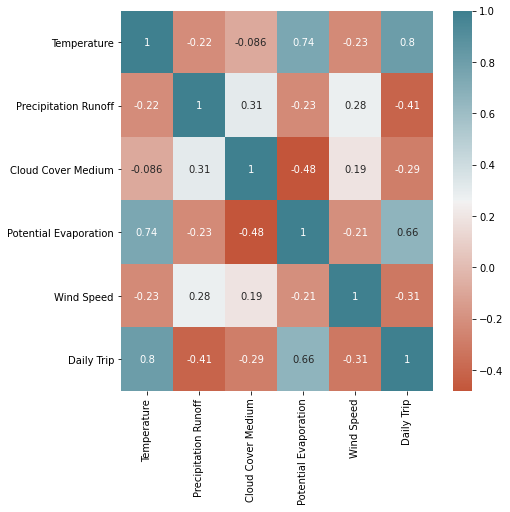

In [20]:
# filter off columns that has the highest corelation (20% of the whole data)
data_corr = data_agg.corr()
uplim = data_corr['Daily Trip'].quantile(q=0.90)
lowlim = data_corr['Daily Trip'].quantile(q=0.10)

col = data_corr[(data_corr['Daily Trip'] > uplim) | (data_corr['Daily Trip'] < lowlim)].index
data_viz = data_agg[col]

import seaborn as sns
plt.figure(figsize = (7,7))
cmap = sns.diverging_palette(20, 215, as_cmap=True)
sns.heatmap(data_viz.corr(), annot = True, cmap = cmap)

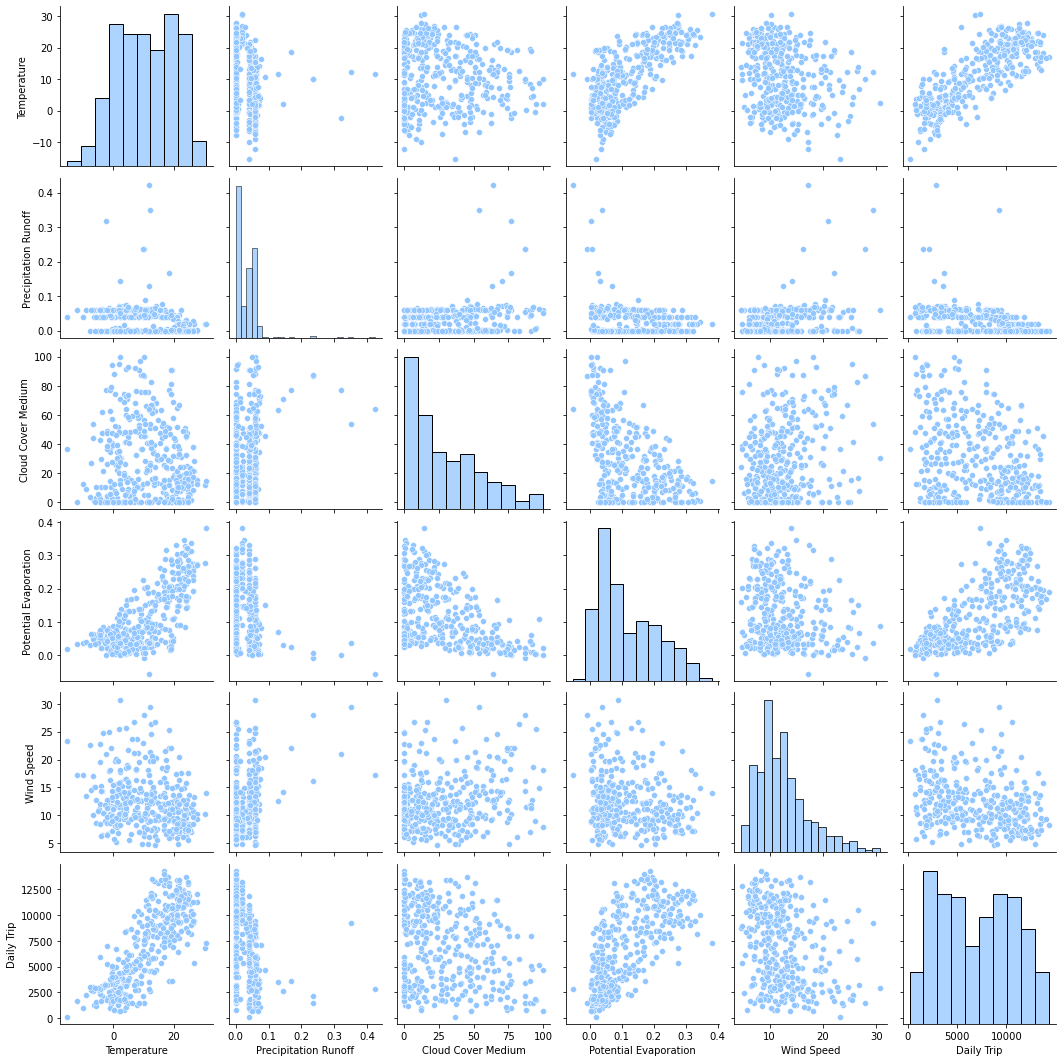

In [21]:
sns.pairplot(data_viz)

---
#### Observations:

We can see from the pair plot graphs, that Temperature, Cloud Cover Medium, Potential Evaporation and Wind Speed has some impacts on the Daily Trip. 
- As the **Temperature** goes low, daily ridership is dropping perhaps due to snow and cold temperature, customer are more reluctant (or even unable) for transportation
- **Cloud cover Medium** as it go higher, the total daily ridership is dropping, this may means raining, or snowing at the area (depending on the season)
- **Potential Evaporation** as it go higher, the total daily ridership is increasing, however it is also have the same trend with temperature, so it means that Potential Evaporation correlated with temperature, as the temperature goes higher, more evaporation happens
- As the **Wind Speed** is increasing, the daily readership having a trend down, we see weak correlation with other factors, which become an additional good factor to predict the ridership. One reason that may explain as the wind speed increases, it may become dangerous for the people to ride the bikes and hence lesser people take the bikes
---

In [30]:
data_viz.columns

Index(['Temperature', 'Precipitation Runoff', 'Cloud Cover Medium',
       'Potential Evaporation', 'Wind Speed', 'Daily Trip'],
      dtype='object')

In [29]:
data_agg.columns

Index(['Temperature', 'Relative Humidity', 'Mean Sea Level Pressure',
       'Precipitation Total', 'Precipitation Runoff', 'Snowfall Amount',
       'Snow Depth', 'Cloud Cover Total', 'Cloud Cover High',
       'Cloud Cover Medium', 'Cloud Cover Low', 'Sunshine Duration',
       'Shortwave Radiation', 'Longwave Radiation', 'UV Radiation',
       'Direct Shortwave Radiation', 'Diffuse Shortwave Radiation',
       'Evapotranspiration', 'Potential Evaporation',
       'FAO Reference Evapotranspiration', 'CAPE', 'PBL Height', 'Wind Gust',
       'Wind Speed', 'Wind Direction', 'Geopotential Height',
       'Vapor Pressure Deficit', 'Total Column Cloud Ice',
       'Total Column Cloud Water', 'Daily Trip'],
      dtype='object')

In [49]:
data_agg.dropna(axis=0, inplace=True)
arima_mod_init = pm.auto_arima(data_agg['Daily Trip'][:-30], suppress_warnings=True,seasonal=True, m=7)
print(arima_mod_init.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  334
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -2922.472
Date:                           Tue, 24 Nov 2020   AIC                           5854.944
Time:                                   22:51:43   BIC                           5873.984
Sample:                                        0   HQIC                          5862.536
                                           - 334                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1105      0.077      1.434      0.152      -0.041       0.262
ma.L1         -0.8377      0.044    -19.243

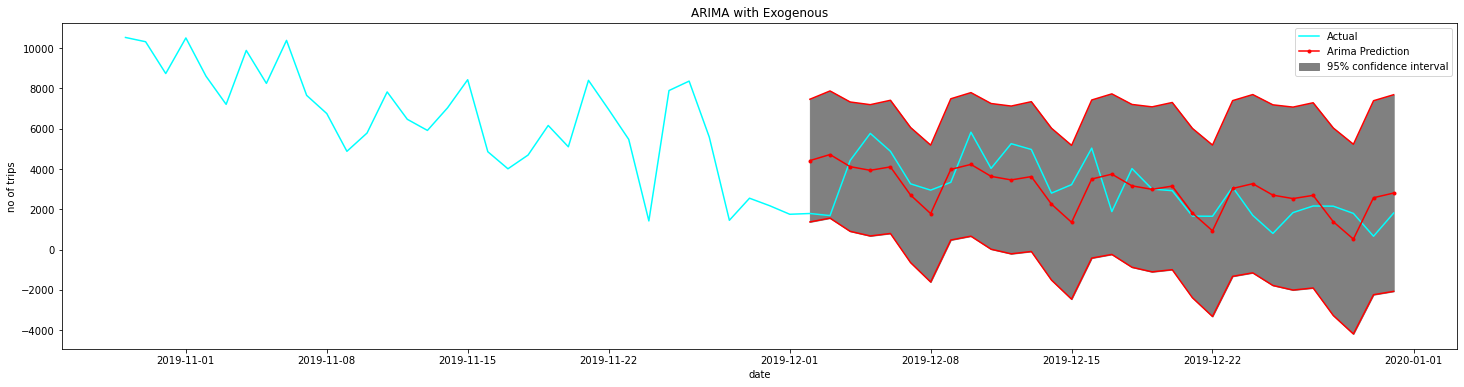

In [77]:
pred, conf = arima_mod_init.predict(30, return_conf_int=True,alpha=0.05)
Test0 = pd.DataFrame()

Test0['test_periods'] = data_agg.index[-30:]
Test0['lower_bounds'] = [i[0] for i in conf ]
Test0['upper_bounds'] = [i[1] for i in conf ]
Test0['prediction'] = np.array(pred)


plt.figure(figsize=(25, 6))
plt.title('ARIMA with Exogenous')
plt.xlabel('date')
plt.ylabel('no of trips')
plt.fill_between( Test0['test_periods'].values, Test0['lower_bounds'].values, Test0['upper_bounds'].values, color='grey', label='95% confidence interval')
plt.plot_date( data_agg.index[300:], data_agg['Daily Trip'][300:], linestyle = 'solid', color = 'cyan', label='Actual', markersize = 0)
plt.plot_date( Test0['test_periods'], Test0['prediction'], linestyle = 'solid', marker = '.', color = 'red', label= 'Arima Prediction')
plt.plot_date( Test0['test_periods'], Test0['upper_bounds'], linestyle = 'solid', markersize=0, color = 'red')
plt.plot_date( Test0['test_periods'], Test0['lower_bounds'], linestyle = 'solid', markersize=0, color = 'red')

plt.legend()
plt.show()

In [53]:
data_agg.dropna(axis=0, inplace=True)
exog = data_agg[['Temperature', 'Precipitation Runoff', 'Cloud Cover Medium', 'Potential Evaporation', 'Wind Speed']][:-30]
arima_mod = pm.auto_arima(data_agg['Daily Trip'][:-30], suppress_warnings=True,exogenous = exog, seasonal=True, m=7)
print(arima_mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  334
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -2805.994
Date:                             Tue, 24 Nov 2020   AIC                           5639.987
Time:                                     22:57:36   BIC                           5693.301
Sample:                                          0   HQIC                          5661.247
                                             - 334                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Temperature             118.0203     24.966      4.727      0.000      69.087     16

C:\Users\tommy\anaconda3\envs\python3.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


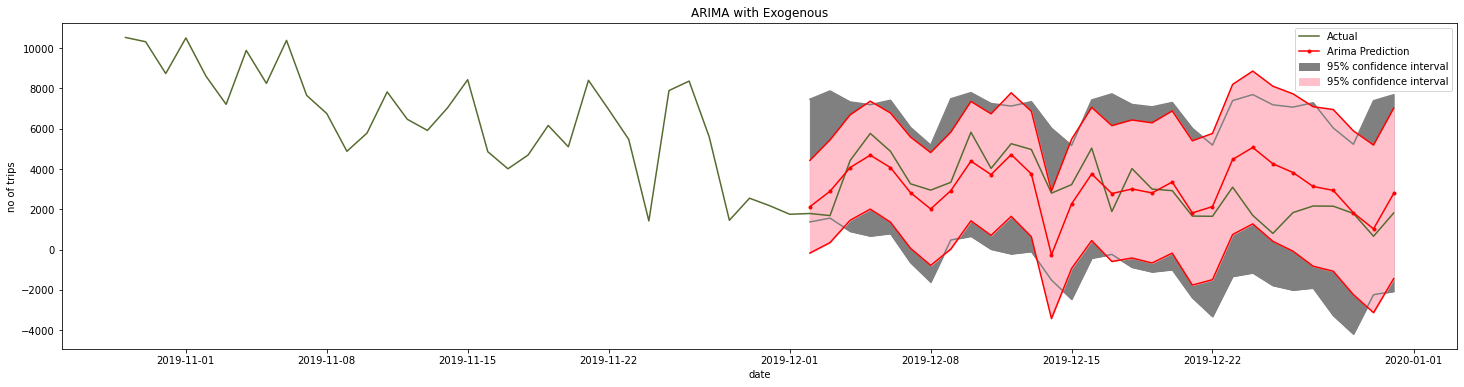

In [63]:
exog_test = data_agg[['Temperature', 'Precipitation Runoff', 'Cloud Cover Medium', 'Potential Evaporation', 'Wind Speed']][-30:]

pred, conf = arima_mod.predict(30, exogenous = exog_test ,return_conf_int=True,alpha=0.05)
Test = pd.DataFrame()

Test['test_periods'] = data_agg.index[-30:]
Test['lower_bounds'] = [i[0] for i in conf ]
Test['upper_bounds'] = [i[1] for i in conf ]
Test['prediction'] = np.array(pred)


plt.figure(figsize=(25, 6))
plt.title('ARIMA with Exogenous')
plt.xlabel('date')
plt.ylabel('no of trips')
plt.plot_date( data_agg.index[300:], data_agg['Daily Trip'][300:], linestyle = 'solid', color = 'darkolivegreen', label='Actual', markersize = 0)

plt.plot_date( Test0['test_periods'], Test0['upper_bounds'], linestyle = 'solid', markersize=0, color = 'grey')
plt.plot_date( Test0['test_periods'], Test0['lower_bounds'], linestyle = 'solid', markersize=0, color = 'grey')
plt.fill_between( Test0['test_periods'].values, Test0['lower_bounds'].values, Test0['upper_bounds'].values, color='grey', label='95% confidence interval')

plt.plot_date( Test['test_periods'], Test['prediction'], linestyle = 'solid', marker = '.', color = 'red', label= 'Arima Prediction')
plt.plot_date( Test['test_periods'], Test['upper_bounds'], linestyle = 'solid', markersize=0, color = 'red')
plt.plot_date( Test['test_periods'], Test['lower_bounds'], linestyle = 'solid', markersize=0, color = 'red')
plt.fill_between( Test['test_periods'].values, Test['lower_bounds'].values, Test['upper_bounds'].values, color='pink', label='95% confidence interval')


plt.legend()
plt.show()

In [74]:
pred0 = Test0['prediction']
pred1 = Test['prediction']
actual = data_agg['Daily Trip'][-30:]

MAPE_ARIMA_initial = Mape(actual, pred0)
MAPE_ARIMA_exog = Mape(actual, pred1)

print('MAD for ARIMA forecast: {:.1f}'.format(mean_absolute_error(actual,pred0)))
print('MAPE for ARIMA forecast: {:.1f}%'.format(MAPE_ARIMA_initial))
print('-'*80)
print('MAD for ARIMA with Exogenous forecast: {:.1f}'.format(mean_absolute_error(actual,pred1)))
print('MAPE for ARIMA with Exogenous forecast: {:.1f}%'.format(MAPE_ARIMA_exog))

MAD for ARIMA forecast: 1119.0
MAPE for ARIMA forecast: 56.3%
--------------------------------------------------------------------------------
MAD for ARIMA with Exogenous forecast: 1028.4
MAPE for ARIMA with Exogenous forecast: 50.9%


### Observations:
As we run our ARIMA models with the additional data set we can observe that the p-value of the variables are less than 0, that all the weather datas are significant. And as we plot the ARIMA model, we can observe that the predictions are quite close with the actual and with the 95% confidence, all the actuals are within the predictions. Exogenous variable helps to make the ARIMA prediction more accurate and reduce the MAD and MAPE of the ARIMA forecast